<a href="https://colab.research.google.com/github/afroditinats/PINNs/blob/main/optuna%20hyperparameter%20tun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.3 MB/s eta 0:00:00


In [3]:
import optuna
import torch
import numpy as np
import time
import joblib
import pandas as pd
from IPython.display import display
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"
from modules import Model
from data import get_data
from pinn import PINN_experiment

activations = {
    "Tanh": torch.nn.Tanh,
    "ReLU": torch.nn.ReLU,
    "LeakyReLU": torch.nn.LeakyReLU,
    "Sigmoid": torch.nn.Sigmoid,
}

optimizers = {
    "Adam": torch.optim.Adam,
    "AdamW": torch.optim.AdamW,
    "SGD": torch.optim.SGD,
    "RMSprop": torch.optim.RMSprop,
    "Adagrad": torch.optim.Adagrad,
    "LBFGS": torch.optim.LBFGS,
}

def modify_network(layers, neurons, activation):
    network = [torch.nn.Linear(2, neurons).double(), activation().double()]
    for _ in range(layers - 2):
        network.append(torch.nn.Linear(neurons, neurons).double())
        network.append(activation().double())
    network.append(torch.nn.Linear(neurons, 1).double())
    return torch.nn.Sequential(*network)

#optuna function
def objective(trial):
    """Objective function to optimize PINN hyperparameters using Optuna."""
    layers = trial.suggest_int("layers", 3, 50)
    neurons = trial.suggest_int("neurons", 5, 50)
    activation_name = trial.suggest_categorical("activation", list(activations.keys()))
    optimizer_name = trial.suggest_categorical("optimizer", list(optimizers.keys()))
    train_val_split = trial.suggest_categorical("train_val_split", [0.6, 0.7, 0.8, 0.9])
    viscosity = trial.suggest_float("viscosity", -1.0, 1.0)
    iterations = trial.suggest_int("iterations", 1000, 10000)
    activation = activations[activation_name]
    optimizer = optimizers[optimizer_name]
    Model.create_network = lambda self: modify_network(layers, neurons, activation)
    model = Model()
    model.adam_optimizer = torch.optim.AdamW(model.network.parameters())
    model.visc = torch.nn.Parameter(torch.tensor([viscosity], dtype=torch.double))
    model.network.register_parameter("visc", model.visc)
    model.lbfgs_optimizer = optimizer(model.network.parameters())
    data = get_data()
    start_time = time.time()

    PINN_experiment(data, [0.0], verbose=False, rerun=True)


    all_results = np.load("./results/pinn_results.npy", allow_pickle=True)
    rmse = all_results[0][-1]

    run_time = time.time() - start_time
    print(f"Trial complete: RMSE={rmse}, Time={run_time}s")

    return rmse

#optimizing the hyperparameters
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  #n_trials


joblib.dump(study, "optuna_pinn_study.pkl")
print("Optuna study saved!")
study = joblib.load("optuna_pinn_study.pkl")
top_trials = sorted(study.trials, key=lambda t: t.value)[:10]

top_results = []
for trial in top_trials:
    top_results.append({
        "RMSE": trial.value,
        "Layers": trial.params["layers"],
        "Neurons": trial.params["neurons"],
        "Activation": trial.params["activation"],
        "Optimizer": trial.params["optimizer"],
        "Train-Val Split": trial.params["train_val_split"],
        "Viscosity": trial.params["viscosity"],
        "Iterations": trial.params["iterations"]
    })

df_top = pd.DataFrame(top_results)
#top 10 results
display(df_top)


[I 2025-03-17 11:24:12,670] A new study created in memory with name: no-name-3fef5ca9-e51b-492a-ae43-e427556814aa


Loaded data.


/content/data.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  tensor_data.append(torch.tensor(entry))
[I 2025-03-17 11:33:20,570] Trial 0 finished with value: 0.3774639385386569 and parameters: {'layers': 50, 'neurons': 21, 'activation': 'ReLU', 'optimizer': 'SGD', 'train_val_split': 0.7, 'viscosity': -0.020020737297935964, 'iterations': 5920}. Best is trial 0 with value: 0.3774639385386569.


PINN test complete.
Trial complete: RMSE=0.3774639385386569, Time=541.0269017219543s
Loaded data.


[I 2025-03-17 11:39:54,055] Trial 1 finished with value: 0.003978849489848615 and parameters: {'layers': 24, 'neurons': 10, 'activation': 'Tanh', 'optimizer': 'LBFGS', 'train_val_split': 0.7, 'viscosity': -0.6901684416634457, 'iterations': 4177}. Best is trial 1 with value: 0.003978849489848615.


PINN test complete.
Trial complete: RMSE=0.003978849489848615, Time=393.3397672176361s
Loaded data.


[I 2025-03-17 12:00:07,654] Trial 2 finished with value: 0.3774639385386999 and parameters: {'layers': 44, 'neurons': 43, 'activation': 'LeakyReLU', 'optimizer': 'LBFGS', 'train_val_split': 0.6, 'viscosity': -0.8159899258526166, 'iterations': 3941}. Best is trial 1 with value: 0.003978849489848615.


PINN test complete.
Trial complete: RMSE=0.3774639385386999, Time=1213.4618017673492s
Loaded data.


[I 2025-03-17 12:34:34,383] Trial 3 finished with value: 0.37746393853846316 and parameters: {'layers': 49, 'neurons': 45, 'activation': 'Tanh', 'optimizer': 'Adagrad', 'train_val_split': 0.9, 'viscosity': -0.2887931095839542, 'iterations': 8507}. Best is trial 1 with value: 0.003978849489848615.


PINN test complete.
Trial complete: RMSE=0.37746393853846316, Time=2066.599943637848s
Loaded data.


[I 2025-03-17 12:39:17,402] Trial 4 finished with value: 5.0775959421000885e-05 and parameters: {'layers': 8, 'neurons': 23, 'activation': 'Tanh', 'optimizer': 'Adam', 'train_val_split': 0.8, 'viscosity': -0.06435724098872986, 'iterations': 6408}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=5.0775959421000885e-05, Time=282.80485582351685s
Loaded data.


[I 2025-03-17 12:58:48,444] Trial 5 finished with value: 0.37746393853864113 and parameters: {'layers': 25, 'neurons': 49, 'activation': 'Sigmoid', 'optimizer': 'Adam', 'train_val_split': 0.8, 'viscosity': -0.10038829053538567, 'iterations': 7148}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.37746393853864113, Time=1170.9278128147125s
Loaded data.


[I 2025-03-17 13:06:04,538] Trial 6 finished with value: 0.37746393853871274 and parameters: {'layers': 14, 'neurons': 37, 'activation': 'Sigmoid', 'optimizer': 'RMSprop', 'train_val_split': 0.6, 'viscosity': 0.5494907030779634, 'iterations': 5770}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.37746393853871274, Time=435.9603662490845s
Loaded data.


[I 2025-03-17 13:21:50,158] Trial 7 finished with value: 0.0024202298358030204 and parameters: {'layers': 27, 'neurons': 21, 'activation': 'Tanh', 'optimizer': 'Adam', 'train_val_split': 0.9, 'viscosity': -0.020236600269587735, 'iterations': 2309}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.0024202298358030204, Time=945.4882462024689s
Loaded data.


[I 2025-03-17 13:24:18,994] Trial 8 finished with value: 0.13933280783407567 and parameters: {'layers': 7, 'neurons': 40, 'activation': 'LeakyReLU', 'optimizer': 'AdamW', 'train_val_split': 0.7, 'viscosity': 0.48951953549031035, 'iterations': 9383}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.13933280783407567, Time=148.69813704490662s
Loaded data.


[I 2025-03-17 13:41:45,713] Trial 9 finished with value: 0.3774639385385619 and parameters: {'layers': 50, 'neurons': 25, 'activation': 'Tanh', 'optimizer': 'Adagrad', 'train_val_split': 0.9, 'viscosity': -0.013064732082337827, 'iterations': 9034}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.3774639385385619, Time=1046.5814726352692s
Loaded data.


[I 2025-03-17 13:42:00,890] Trial 10 finished with value: 0.15910938016659584 and parameters: {'layers': 3, 'neurons': 5, 'activation': 'ReLU', 'optimizer': 'Adam', 'train_val_split': 0.8, 'viscosity': 0.9819997701676533, 'iterations': 1767}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.15910938016659584, Time=15.004042625427246s
Loaded data.


[I 2025-03-17 14:01:04,397] Trial 11 finished with value: 0.004337582179059874 and parameters: {'layers': 36, 'neurons': 19, 'activation': 'Tanh', 'optimizer': 'Adam', 'train_val_split': 0.9, 'viscosity': -0.4746882120555562, 'iterations': 1054}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.004337582179059874, Time=1143.3668134212494s
Loaded data.


[I 2025-03-17 14:29:53,311] Trial 12 finished with value: 0.0060737890974252775 and parameters: {'layers': 33, 'neurons': 32, 'activation': 'Tanh', 'optimizer': 'Adam', 'train_val_split': 0.8, 'viscosity': 0.350899733939664, 'iterations': 2962}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.0060737890974252775, Time=1728.7615277767181s
Loaded data.


[I 2025-03-17 14:36:37,128] Trial 13 finished with value: 0.00010546067677517129 and parameters: {'layers': 17, 'neurons': 16, 'activation': 'Tanh', 'optimizer': 'Adam', 'train_val_split': 0.8, 'viscosity': 0.24508032744256414, 'iterations': 7243}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.00010546067677517129, Time=403.65794706344604s
Loaded data.


[I 2025-03-17 14:42:24,630] Trial 14 finished with value: 0.00017530998009892082 and parameters: {'layers': 15, 'neurons': 15, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': 0.28316849178325476, 'iterations': 7373}. Best is trial 4 with value: 5.0775959421000885e-05.


PINN test complete.
Trial complete: RMSE=0.00017530998009892082, Time=347.3461949825287s
Loaded data.


[I 2025-03-17 14:54:58,457] Trial 15 finished with value: 4.197951287102239e-05 and parameters: {'layers': 15, 'neurons': 30, 'activation': 'Tanh', 'optimizer': 'RMSprop', 'train_val_split': 0.8, 'viscosity': 0.7604500603541968, 'iterations': 7189}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=4.197951287102239e-05, Time=753.6807885169983s
Loaded data.


[I 2025-03-17 14:59:50,544] Trial 16 finished with value: 0.13330038628013313 and parameters: {'layers': 9, 'neurons': 30, 'activation': 'LeakyReLU', 'optimizer': 'RMSprop', 'train_val_split': 0.8, 'viscosity': 0.9513178956700852, 'iterations': 5160}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=0.13330038628013313, Time=291.91507625579834s
Loaded data.


[I 2025-03-17 15:08:59,755] Trial 17 finished with value: 0.37746393853864596 and parameters: {'layers': 19, 'neurons': 34, 'activation': 'Sigmoid', 'optimizer': 'RMSprop', 'train_val_split': 0.8, 'viscosity': 0.7240473407736496, 'iterations': 7977}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=0.37746393853864596, Time=549.0809254646301s
Loaded data.


[I 2025-03-17 15:13:59,780] Trial 18 finished with value: 0.1382904540307943 and parameters: {'layers': 10, 'neurons': 26, 'activation': 'ReLU', 'optimizer': 'AdamW', 'train_val_split': 0.8, 'viscosity': -0.3756019133663161, 'iterations': 6571}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=0.1382904540307943, Time=299.8606162071228s
Loaded data.


[I 2025-03-17 15:15:38,938] Trial 19 finished with value: 0.0004937975191416762 and parameters: {'layers': 3, 'neurons': 27, 'activation': 'Tanh', 'optimizer': 'RMSprop', 'train_val_split': 0.6, 'viscosity': 0.7804984137118569, 'iterations': 4627}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=0.0004937975191416762, Time=98.93377709388733s
Loaded data.


[I 2025-03-17 15:21:44,004] Trial 20 finished with value: 0.010797921300882257 and parameters: {'layers': 20, 'neurons': 11, 'activation': 'Tanh', 'optimizer': 'RMSprop', 'train_val_split': 0.8, 'viscosity': 0.19334340587579824, 'iterations': 6476}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=0.010797921300882257, Time=364.9215421676636s
Loaded data.


[I 2025-03-17 15:27:15,877] Trial 21 finished with value: 4.304516348412634e-05 and parameters: {'layers': 14, 'neurons': 16, 'activation': 'Tanh', 'optimizer': 'Adam', 'train_val_split': 0.8, 'viscosity': 0.13109516324042672, 'iterations': 9938}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=4.304516348412634e-05, Time=331.7341191768646s
Loaded data.


[I 2025-03-17 15:34:41,853] Trial 22 finished with value: 5.5151795536127867e-05 and parameters: {'layers': 12, 'neurons': 23, 'activation': 'Tanh', 'optimizer': 'Adam', 'train_val_split': 0.8, 'viscosity': -0.6112290378030971, 'iterations': 9898}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=5.5151795536127867e-05, Time=445.84526801109314s
Loaded data.


[I 2025-03-17 15:36:59,728] Trial 23 finished with value: 7.3964516367517e-05 and parameters: {'layers': 6, 'neurons': 16, 'activation': 'Tanh', 'optimizer': 'Adam', 'train_val_split': 0.8, 'viscosity': 0.13355871093422894, 'iterations': 8263}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=7.3964516367517e-05, Time=137.72544121742249s
Loaded data.


[I 2025-03-17 15:54:19,053] Trial 24 finished with value: 7.06645114423478e-05 and parameters: {'layers': 21, 'neurons': 29, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.280872963118046, 'iterations': 9997}. Best is trial 15 with value: 4.197951287102239e-05.


PINN test complete.
Trial complete: RMSE=7.06645114423478e-05, Time=1039.182591676712s
Loaded data.


[I 2025-03-17 15:57:54,796] Trial 25 finished with value: 3.1152055914757554e-05 and parameters: {'layers': 12, 'neurons': 11, 'activation': 'Tanh', 'optimizer': 'AdamW', 'train_val_split': 0.8, 'viscosity': -0.9508809470573898, 'iterations': 7797}. Best is trial 25 with value: 3.1152055914757554e-05.


PINN test complete.
Trial complete: RMSE=3.1152055914757554e-05, Time=215.58619594573975s
Loaded data.


[I 2025-03-17 16:00:03,119] Trial 26 finished with value: 0.15748538476939072 and parameters: {'layers': 30, 'neurons': 6, 'activation': 'LeakyReLU', 'optimizer': 'AdamW', 'train_val_split': 0.8, 'viscosity': -0.9786138042569588, 'iterations': 7928}. Best is trial 25 with value: 3.1152055914757554e-05.


PINN test complete.
Trial complete: RMSE=0.15748538476939072, Time=128.18379640579224s
Loaded data.


[I 2025-03-17 16:02:19,841] Trial 27 finished with value: 0.3774639384133834 and parameters: {'layers': 13, 'neurons': 14, 'activation': 'Sigmoid', 'optimizer': 'AdamW', 'train_val_split': 0.7, 'viscosity': 0.5203680197636209, 'iterations': 9062}. Best is trial 25 with value: 3.1152055914757554e-05.


PINN test complete.
Trial complete: RMSE=0.3774639384133834, Time=136.56838250160217s
Loaded data.


[I 2025-03-17 16:03:41,047] Trial 28 finished with value: 0.13840960160632185 and parameters: {'layers': 16, 'neurons': 9, 'activation': 'ReLU', 'optimizer': 'AdamW', 'train_val_split': 0.6, 'viscosity': 0.7026218763362642, 'iterations': 8942}. Best is trial 25 with value: 3.1152055914757554e-05.


PINN test complete.
Trial complete: RMSE=0.13840960160632185, Time=80.9809079170227s
Loaded data.


[I 2025-03-17 16:07:17,981] Trial 29 finished with value: 0.1411743372111078 and parameters: {'layers': 22, 'neurons': 19, 'activation': 'ReLU', 'optimizer': 'LBFGS', 'train_val_split': 0.7, 'viscosity': -0.18786185853314616, 'iterations': 7776}. Best is trial 25 with value: 3.1152055914757554e-05.


PINN test complete.
Trial complete: RMSE=0.1411743372111078, Time=216.7635006904602s
Loaded data.


[I 2025-03-17 16:11:06,508] Trial 30 finished with value: 5.2332214444013626e-05 and parameters: {'layers': 11, 'neurons': 13, 'activation': 'Tanh', 'optimizer': 'Adagrad', 'train_val_split': 0.8, 'viscosity': -0.48446271296178745, 'iterations': 5258}. Best is trial 25 with value: 3.1152055914757554e-05.


PINN test complete.
Trial complete: RMSE=5.2332214444013626e-05, Time=228.37177276611328s
Loaded data.


[I 2025-03-17 16:15:41,260] Trial 31 finished with value: 3.7268522427796115e-05 and parameters: {'layers': 8, 'neurons': 22, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.9701940750034694, 'iterations': 6868}. Best is trial 25 with value: 3.1152055914757554e-05.


PINN test complete.
Trial complete: RMSE=3.7268522427796115e-05, Time=274.6044969558716s
Loaded data.


[I 2025-03-17 16:18:01,665] Trial 32 finished with value: 3.900518573209593e-05 and parameters: {'layers': 5, 'neurons': 19, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.9595799682356839, 'iterations': 6818}. Best is trial 25 with value: 3.1152055914757554e-05.


PINN test complete.
Trial complete: RMSE=3.900518573209593e-05, Time=140.25572896003723s
Loaded data.


[I 2025-03-17 16:20:21,580] Trial 33 finished with value: 3.790663493792428e-05 and parameters: {'layers': 5, 'neurons': 19, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.9376949951453618, 'iterations': 6825}. Best is trial 25 with value: 3.1152055914757554e-05.


PINN test complete.
Trial complete: RMSE=3.790663493792428e-05, Time=139.74528002738953s
Loaded data.


[I 2025-03-17 16:23:16,662] Trial 34 finished with value: 2.9197184034507267e-05 and parameters: {'layers': 6, 'neurons': 20, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.99941927873629, 'iterations': 6137}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=2.9197184034507267e-05, Time=174.9228551387787s
Loaded data.


[I 2025-03-17 16:25:05,654] Trial 35 finished with value: 4.8444596147658865e-05 and parameters: {'layers': 7, 'neurons': 9, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.7, 'viscosity': -0.8079499703728629, 'iterations': 5970}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=4.8444596147658865e-05, Time=108.85729742050171s
Loaded data.


[I 2025-03-17 16:27:08,052] Trial 36 finished with value: 7.470773099204881e-05 and parameters: {'layers': 4, 'neurons': 22, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.8273495786428395, 'iterations': 6056}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=7.470773099204881e-05, Time=122.18849396705627s
Loaded data.


[I 2025-03-17 16:33:11,430] Trial 37 finished with value: 0.3774639385358657 and parameters: {'layers': 40, 'neurons': 18, 'activation': 'LeakyReLU', 'optimizer': 'SGD', 'train_val_split': 0.6, 'viscosity': -0.670538630528642, 'iterations': 4685}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=0.3774639385358657, Time=363.204478263855s
Loaded data.


[I 2025-03-17 16:39:21,251] Trial 38 finished with value: 0.11264910776769124 and parameters: {'layers': 10, 'neurons': 24, 'activation': 'Sigmoid', 'optimizer': 'SGD', 'train_val_split': 0.9, 'viscosity': -0.8285281416529313, 'iterations': 3560}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=0.11264910776769124, Time=369.5984764099121s
Loaded data.


[I 2025-03-17 16:43:47,725] Trial 39 finished with value: 4.424876079554724e-05 and parameters: {'layers': 8, 'neurons': 21, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.9045757787858641, 'iterations': 5584}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=4.424876079554724e-05, Time=266.3303382396698s
Loaded data.


[I 2025-03-17 16:45:38,835] Trial 40 finished with value: 5.415259445384439e-05 and parameters: {'layers': 6, 'neurons': 12, 'activation': 'Tanh', 'optimizer': 'LBFGS', 'train_val_split': 0.8, 'viscosity': -0.7151250173040911, 'iterations': 7587}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=5.415259445384439e-05, Time=110.96044945716858s
Loaded data.


[I 2025-03-17 16:47:59,593] Trial 41 finished with value: 7.1414493923799e-05 and parameters: {'layers': 5, 'neurons': 19, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.9700087737095308, 'iterations': 6820}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=7.1414493923799e-05, Time=140.6157946586609s
Loaded data.


[I 2025-03-17 16:52:11,483] Trial 42 finished with value: 5.017869878879916e-05 and parameters: {'layers': 9, 'neurons': 18, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.882073826993677, 'iterations': 6236}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=5.017869878879916e-05, Time=251.74690699577332s
Loaded data.


[I 2025-03-17 16:52:54,909] Trial 43 finished with value: 0.005851920533919241 and parameters: {'layers': 3, 'neurons': 7, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.8, 'viscosity': -0.7297036182240237, 'iterations': 6839}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=0.005851920533919241, Time=43.27825856208801s
Loaded data.


[I 2025-03-17 16:56:07,100] Trial 44 finished with value: 3.5497603894446096e-05 and parameters: {'layers': 6, 'neurons': 21, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.9, 'viscosity': -0.9853254109078409, 'iterations': 8448}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=3.5497603894446096e-05, Time=192.03593683242798s
Loaded data.


[I 2025-03-17 17:02:54,659] Trial 45 finished with value: 3.64951679574669e-05 and parameters: {'layers': 12, 'neurons': 21, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.9, 'viscosity': -0.5603944308625368, 'iterations': 8575}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=3.64951679574669e-05, Time=407.41772866249084s
Loaded data.


[I 2025-03-17 17:15:32,191] Trial 46 finished with value: 6.851339851160006e-05 and parameters: {'layers': 18, 'neurons': 25, 'activation': 'Tanh', 'optimizer': 'Adagrad', 'train_val_split': 0.9, 'viscosity': -0.5707180701118237, 'iterations': 8456}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=6.851339851160006e-05, Time=757.3113791942596s
Loaded data.


[I 2025-03-17 17:20:19,693] Trial 47 finished with value: 0.13972454635678808 and parameters: {'layers': 12, 'neurons': 21, 'activation': 'LeakyReLU', 'optimizer': 'SGD', 'train_val_split': 0.9, 'viscosity': -0.7565524228890721, 'iterations': 8705}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=0.13972454635678808, Time=287.27135968208313s
Loaded data.


[I 2025-03-17 17:45:47,466] Trial 48 finished with value: 0.3774639385385082 and parameters: {'layers': 46, 'neurons': 50, 'activation': 'ReLU', 'optimizer': 'AdamW', 'train_val_split': 0.9, 'viscosity': -0.6035204736978653, 'iterations': 9304}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=0.3774639385385082, Time=1527.6120026111603s
Loaded data.


[I 2025-03-17 17:50:31,331] Trial 49 finished with value: 3.688266359718108e-05 and parameters: {'layers': 7, 'neurons': 28, 'activation': 'Tanh', 'optimizer': 'SGD', 'train_val_split': 0.9, 'viscosity': -0.8912944913177114, 'iterations': 8212}. Best is trial 34 with value: 2.9197184034507267e-05.


PINN test complete.
Trial complete: RMSE=3.688266359718108e-05, Time=283.7135989665985s
Optuna study saved!


,RMSE,Layers,Neurons,Activation,Optimizer,Train-Val Split,Viscosity,Iterations
0,0.000029,6,20,Tanh,SGD,0.8,-0.999419,6137
1,0.000031,12,11,Tanh,AdamW,0.8,-0.950881,7797
2,0.000035,6,21,Tanh,SGD,0.9,-0.985325,8448
3,0.000036,12,21,Tanh,SGD,0.9,-0.560394,8575
4,0.000037,7,28,Tanh,SGD,0.9,-0.891294,8212
5,0.000037,8,22,Tanh,SGD,0.8,-0.970194,6868
6,0.000038,5,19,Tanh,SGD,0.8,-0.937695,6825
7,0.000039,5,19,Tanh,SGD,0.8,-0.959580,6818
8,0.000042,15,30,Tanh,RMSprop,0.8,0.760450,7189
9,0.000043,14,16,Tanh,Adam,0.8,0.131095,9938


Top 10 hyperparameter sets found!


In [11]:
import pandas as pd
from IPython.display import display

#top 10 sets with the lowest rmse / the [:50] prints all the results
top_trials = sorted(study.trials, key=lambda t: t.value)[:50]
top_results = []
for trial in top_trials:
    top_results.append({
        "RMSE": trial.value,
        "Layers": trial.params["layers"],
        "Neurons": trial.params["neurons"],
        "Activation": trial.params["activation"],
        "Optimizer": trial.params["optimizer"],
        "Train-Val Split": trial.params["train_val_split"],
        "Viscosity": trial.params["viscosity"],
        "Iterations": trial.params["iterations"]
    })

df_top = pd.DataFrame(top_results)
display(df_top)
df_top.to_csv("top_hyperparameters.csv", index=False)
print("Top hyperparameter sets saved as 'top_hyperparameters.csv'.")


,RMSE,Layers,Neurons,Activation,Optimizer,Train-Val Split,Viscosity,Iterations
0,0.000029,6,20,Tanh,SGD,0.8,-0.999419,6137
1,0.000031,12,11,Tanh,AdamW,0.8,-0.950881,7797
2,0.000035,6,21,Tanh,SGD,0.9,-0.985325,8448
3,0.000036,12,21,Tanh,SGD,0.9,-0.560394,8575
4,0.000037,7,28,Tanh,SGD,0.9,-0.891294,8212
5,0.000037,8,22,Tanh,SGD,0.8,-0.970194,6868
6,0.000038,5,19,Tanh,SGD,0.8,-0.937695,6825
7,0.000039,5,19,Tanh,SGD,0.8,-0.959580,6818
8,0.000042,15,30,Tanh,RMSprop,0.8,0.760450,7189
9,0.000043,14,16,Tanh,Adam,0.8,0.131095,9938


Top hyperparameter sets saved as 'top_hyperparameters.csv'.


In [6]:
import optuna.visualization as vis

fig = vis.plot_param_importances(study)
fig.show()


In [7]:
fig = vis.plot_optimization_history(study)
fig.show()


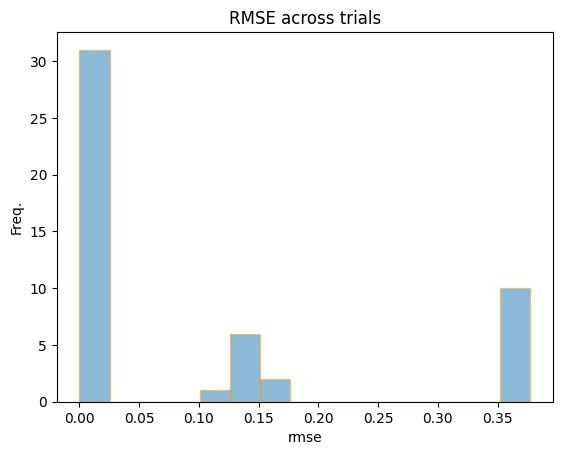

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

df_top.to_excel("top_hyperparameters.xlsx", index=False)
fig, ax = plt.subplots()
ax.hist(rmse_values, bins=15, edgecolor="orange", alpha=0.5)
ax.set_xlabel("rmse")
ax.set_ylabel("Freq.")
ax.set_title("RMSE across trials")
plt.savefig("rmse_distribution.png")

